In [ ]:
%%capture
! pip install arviz==0.11.1
! pip install pymc3==3.10.0
! pip install plotly==4.14.3

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

sns.set_context('talk')

In [ ]:
howell = pd.read_csv("https://github.com/LegrandNico/CognitiveModeling/raw/master/notebooks/data/howell.csv", delimiter=";")

In [ ]:
howell.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


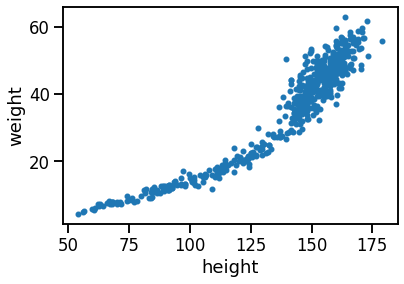

In [ ]:
howell.plot.scatter(x='height', y='weight')

In [ ]:
pd.options.plotting.backend = "plotly"

In [ ]:
howell.plot.scatter(x='height', y='weight')

In [ ]:
pd.options.plotting.backend = "matplotlib"

Now, we are going to fit this data with two slightly different models, a linear one and a
polynomial of order 2, also known as a parabolic or quadratic model.

In [ ]:
x = howell.height.to_numpy()
y = howell.weight.to_numpy()

order = 2
xp = np.vstack([x**i for i in range(1, order+1)])

In [ ]:
x_1s = (xp - xp.mean(axis=1, keepdims=True)) / xp.std(axis=1, keepdims=True)
y_1s = (y - y.mean()) / y.std()

# Linear model
$$ \alpha \sim \mathcal{N}(0, 1)$$
$$ \beta \sim \mathcal{N}(0, 10)$$
$$ \epsilon \sim |\mathcal{N}(0, 5)|$$
$$ y \sim \mathcal{N}(\mu = \alpha + x\beta, \epsilon)$$


In [ ]:
with pm.Model() as model_l:
  α = pm.Normal('α', mu=0, sd=1)
  β = pm.Normal('β', mu=0, sd=10)
  ϵ = pm.HalfNormal('ϵ', 5)
  μ = α + β * x_1s[0]
  y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)
  trace_l = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ϵ, β, α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 6 seconds.


In [ ]:
from bokeh.io import output_notebook

output_notebook()
az.plot_trace(trace_l, backend="bokeh")

array([[Figure(id='1001', ...), Figure(id='1037', ...)],
       [Figure(id='1073', ...), Figure(id='1109', ...)],
       [Figure(id='1144', ...), Figure(id='1180', ...)]], dtype=object)

# Quadratic model
$$ \alpha \sim \mathcal{N}(0, 1)$$
$$ \beta_{1} \sim \mathcal{N}(0, 10)$$
$$ \beta_{2} \sim \mathcal{N}(0, 10)$$
$$ \epsilon \sim |\mathcal{N}(0, 5)|$$
$$ y \sim \mathcal{N}(\mu = \alpha + x\beta_{1} + x^{2}\beta_{2}, \epsilon)$$

In [ ]:
with pm.Model() as model_p:
  α = pm.Normal('α', mu=0, sd=1)
  β = pm.Normal('β', mu=0, sd=10, shape=order)
  ϵ = pm.HalfNormal('ϵ', 5)
  μ = α + pm.math.dot(β, x_1s)
  y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)
  trace_p = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ϵ, β, α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 25 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5e0b4e93d0>,
      dtype=object)

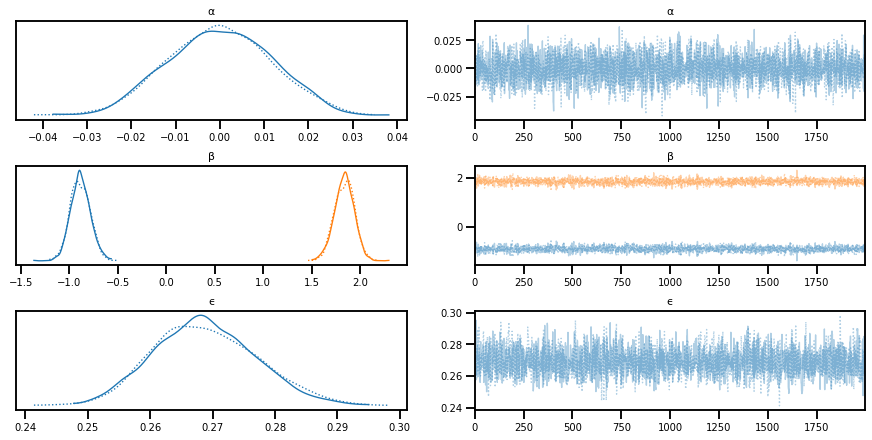

In [ ]:
az.plot_trace(trace_p)

In [ ]:
with pm.Model() as model_p2:
  α = pm.Normal('α', mu=0, sd=1)
  β1 = pm.Normal('β1', mu=0, sd=10)
  β2 = pm.Normal('β2', mu=0, sd=10)
  ϵ = pm.HalfCauchy('ϵ', 5)
  μ = α + β1 * x_1s[0] + β2 * x_1s[0]**2
  y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)
  trace_p2 = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ϵ, β2, β1, α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 8 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5e0ac51450>,
      dtype=object)

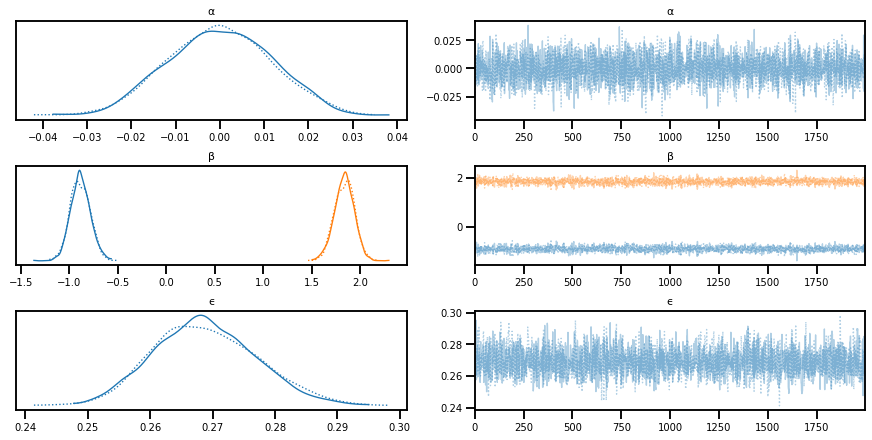

In [ ]:
az.plot_trace(trace_p2)

# Plot

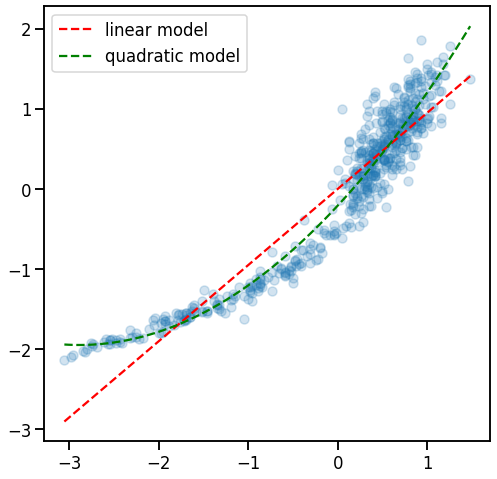

In [ ]:
x_new = np.linspace(x_1s[0].min(), x_1s[0].max(), 100)  # For model lines

plt.figure(figsize=(8, 8))
plt.scatter(x_1s[0], y_1s, alpha=0.2)

# Coefficients for the linear regression
α_l_post = trace_l['posterior']['α'].values.mean()
β_l_post = trace_l['posterior']['β'].values.mean()
y_pred = α_l_post + β_l_post * x_new
plt.plot(x_new, y_pred, 'r--', label='linear model')

# Coefficients for the quadratic regression
α_l_post = trace_p2['posterior']['α'].values.mean()
β_l_post = trace_p2['posterior']['β1'].values.mean()
β_2_post = trace_p2['posterior']['β2'].values.mean()

y_pred = α_l_post + β_l_post * x_new + β_2_post * x_new**2
plt.plot(x_new, y_pred, 'g--', label='quadratic model')

plt.legend()

## Posterior predictive checks

In [ ]:
y_l = pm.sample_posterior_predictive(trace_l, 2000, model=model_l)['y_pred']
y_p = pm.sample_posterior_predictive(trace_p2, 2000, model=model_p2)['y_pred']

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1691: UserWarning:

samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample



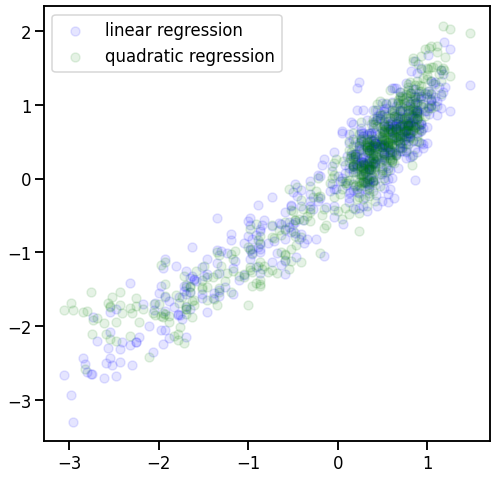

In [ ]:
plt.subplots(figsize=(8, 8))
plt.scatter(x_1s[0], y_l[0, 0], color='b', alpha=0.1, label='linear regression')
plt.scatter(x_1s[0], y_p[0], color='g', alpha=0.1, label='quadratic regression')
plt.legend()

## IQR

([], <a list of 0 Text major ticklabel objects>)

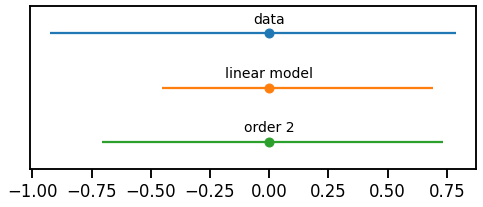

In [ ]:
plt.figure(figsize=(8, 3))
data = [y_1s, y_l[:, 0, :], y_p]
labels = ['data', 'linear model', 'order 2']
for i, d in enumerate(data):
  mean = d.mean()
  err = np.percentile(d, [25, 75])
  plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
  plt.text(mean, -i+0.2, labels[i], ha='center', fontsize=14)
plt.ylim([-i-0.5, 0.5])
plt.yticks([])

## p-value

Bayesian p-values are the probability of getting a simulated statistic equal or more extreme than a statistic from the data. If the data and simulation agrees, we should expect a -value around 0.5, otherwise we are in the presence of a biased posterior predictive distribution.

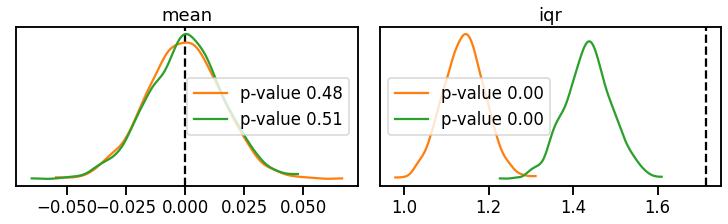

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)
def iqr(x, a=0):
  return np.subtract(*np.percentile(x, [75, 25], axis=a))
for idx, func in enumerate([np.mean, iqr]):
  T_obs = func(y_1s)
  ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
  for d_sim, c in zip([y_l[:, 0, :], y_p], ['C1', 'C2']):
    T_sim = func(d_sim, 1)
    p_value = np.mean(T_sim >= T_obs)
    az.plot_kde(T_sim, plot_kwargs={'color': c}, label=f'p-value {p_value:.2f}', ax=ax[idx])
  ax[idx].set_title(func.__name__)
  ax[idx].set_yticks([])
  ax[idx].legend()

# Model comparison

## WAIC

In [ ]:
az.waic(trace_l)

Computed from 4000 by 544 log-likelihood matrix

          Estimate       SE
elpd_waic  -186.29    14.30
p_waic        3.03        -

In [ ]:
az.waic(trace_p)

Computed from 4000 by 544 log-likelihood matrix

          Estimate       SE
elpd_waic   -58.11    20.37
p_waic        3.71        -

In [ ]:
comp = pm.compare({'linear':trace_l, 'quadratic':trace_p}, method='BB-pseudo-BMA', ic='waic')
comp

/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:147: UserWarning:

The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking



,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
quadratic,0,-58.110993,3.709744,0.000000,0.951893,20.370833,0.000000,False,log
linear,1,-186.287029,3.027557,128.176036,0.048107,14.297081,15.760295,False,log


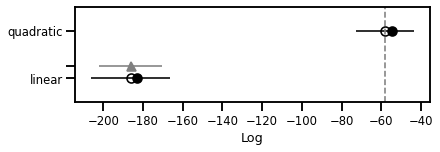

In [ ]:
az.plot_compare(comp)